### Import Dependencies

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [87]:
# Optional: Install tqdm for progress bars if not already installed
# !pip install tqdm
from tqdm import tqdm

In [88]:
# %load_ext jupyter_black
# %jupyter_black

In [89]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("GPU not available. Training will use CPU (slower).")


Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Memory: 6.44 GB


In [90]:
# Training Configuration
TESTING_MODE = False  # Set to False for full training
SUBSET_PERCENTAGE = 0.10  # Use 10% of dataset when testing
NUM_EPOCHS = 2 if TESTING_MODE else 5
BATCH_SIZE = 64
NUM_WORKERS = 4  # Parallel data loading (0 if you have issues on Windows)

print(f"Configuration:")
print(f"  Testing Mode: {TESTING_MODE}")
if TESTING_MODE:
    print(f"  Using {SUBSET_PERCENTAGE*100}% of dataset")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")

Configuration:
  Testing Mode: False
  Epochs: 5
  Batch Size: 64


### Configuration Settings

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [91]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [92]:
dataset = datasets.ImageFolder("../Dataset", transform=transform)

In [93]:
# Get number of classes before subsetting
targets_size = len(dataset.class_to_idx)
print(f"Number of classes: {targets_size}")

Number of classes: 39


In [94]:
# Apply subset for testing mode
if TESTING_MODE:
    subset_size = int(len(dataset) * SUBSET_PERCENTAGE)
    dataset = torch.utils.data.Subset(dataset, range(subset_size))
    print(
        f"Testing mode: Using {len(dataset)} images ({SUBSET_PERCENTAGE*100}% of full dataset)"
    )
else:
    print(f"Full training mode: Using all {len(dataset)} images")

Full training mode: Using all 61486 images


In [95]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: ../Dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [96]:
indices = list(range(len(dataset)))

In [97]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [98]:
validation = int(np.floor(0.70 * split))  # validation

In [99]:
print(0, validation, split, len(dataset))

0 36584 52263 61486


In [100]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :36584
length of validation size :15679
length of test size :24902


In [101]:
np.random.shuffle(indices)

### Split into Train and Test

In [102]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [103]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [104]:
# model = models.vgg16(pretrained=True)

In [105]:
# for params in model.parameters():
#     params.requires_grad = False

In [106]:
# model

In [107]:
# n_features = model.classifier[0].in_features
# n_features

In [108]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [109]:
# model

### Original Modeling

In [110]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [111]:
model = CNN(targets_size)

In [112]:
model.to(device)
print(f"Model moved to: {device}")

Model moved to: cuda


In [113]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [114]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [115]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []

        # Add progress bar for training
        pbar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs} [Train]")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

            # Update progress bar
            pbar.set_postfix({"loss": f"{loss.item():.3f}"})

        train_loss = np.mean(train_loss)

        validation_loss = []

        # Add progress bar for validation
        pbar_val = tqdm(validation_loader, desc=f"Epoch {e+1}/{epochs} [Val]")
        for inputs, targets in pbar_val:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

            pbar_val.set_postfix({"loss": f"{loss.item():.3f}"})

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Val_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [116]:
# Create data loaders with optimization settings
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=test_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
validation_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=validation_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(validation_loader)}")
print(f"  Test batches: {len(test_loader)}")

Data loaders created:
  Train batches: 572
  Validation batches: 245
  Test batches: 145


In [117]:
print(f"\nStarting training for {NUM_EPOCHS} epochs...")
print(f"Using device: {device}\n")

train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, NUM_EPOCHS
)

print("\n✓ Training completed!")


Starting training for 5 epochs...
Using device: cuda



Epoch 1/5 [Val]: 100%|██████████| 245/245 [05:28<00:00,  1.34s/it, loss=1.193]


Epoch : 1/5 Train_loss:2.487 Val_loss:1.489 Duration:1:02:34.634496


Epoch 2/5 [Val]: 100%|██████████| 245/245 [05:22<00:00,  1.31s/it, loss=1.033]


Epoch : 2/5 Train_loss:1.322 Val_loss:1.248 Duration:0:32:53.505781


Epoch 3/5 [Val]: 100%|██████████| 245/245 [05:25<00:00,  1.33s/it, loss=1.051]


Epoch : 3/5 Train_loss:1.077 Val_loss:1.133 Duration:0:32:48.219760


Epoch 4/5 [Val]: 100%|██████████| 245/245 [05:22<00:00,  1.31s/it, loss=0.974]


Epoch : 4/5 Train_loss:0.897 Val_loss:0.902 Duration:0:32:45.695814


Epoch 5/5 [Val]: 100%|██████████| 245/245 [05:25<00:00,  1.33s/it, loss=0.700]

Epoch : 5/5 Train_loss:0.762 Val_loss:0.795 Duration:0:32:54.082324

✓ Training completed!


### Save the Model

In [118]:
# Save the trained model
model_filename = "plant_disease_model_1.pt"
torch.save(model.state_dict(), model_filename)
print(f"✓ Model saved to: {model_filename}")

✓ Model saved to: plant_disease_model_1.pt


### Load Model

In [119]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("plant_disease_model_1.pt", map_location=device))
model.to(device)
model.eval()
print(f"Model loaded and moved to: {device}")

Model loaded and moved to: cuda


In [120]:
# %matplotlib notebook

### Plot the loss

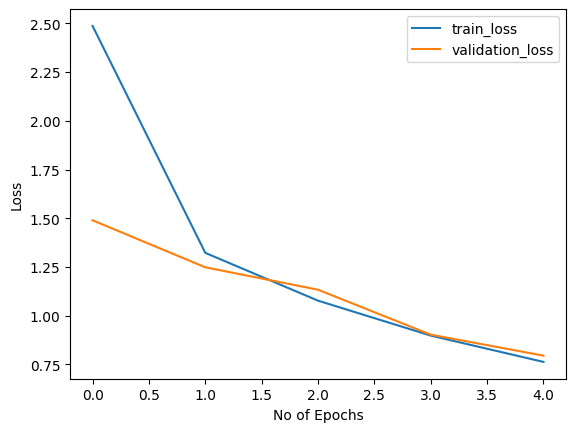

In [121]:
plt.plot(train_losses, label="train_loss")
plt.plot(validation_losses, label="validation_loss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Accuracy

In [122]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [123]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [124]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.8977421823748086
Test Accuracy : 0.8660956304889948
Validation Accuracy : 0.8645959563747688


In [125]:
print("=" * 60)
print("TRAINING COMPLETE - SUMMARY")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Device: {device}")
print(f"  Testing Mode: {TESTING_MODE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"\nDataset:")
print(f"  Total samples: {len(dataset)}")
print(f"  Number of classes: {targets_size}")
print(f"  Train samples: {validation}")
print(f"  Validation samples: {split - validation}")
print(f"  Test samples: {len(dataset) - split}")
print(f"\nAccuracy:")
print(f"  Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Validation Accuracy: {validation_acc:.4f} ({validation_acc*100:.2f}%)")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\nModel saved to: plant_disease_model_1.pt")
print("=" * 60)
print("\nNext steps:")
if TESTING_MODE:
    print("  1. Set TESTING_MODE = False in the configuration cell")
    print("  2. Re-run all cells for full training")
    print("  3. Full training will take 4-7 hours on CPU or 15-40 min on GPU")
else:
    print("  ✓ Full training complete!")
    print("  1. Use the saved model for predictions")
    print("  2. Consider transfer learning with VGG16 for better accuracy")
print("=" * 60)

TRAINING COMPLETE - SUMMARY

Configuration:
  Device: cuda
  Testing Mode: False
  Epochs: 5
  Batch Size: 64

Dataset:
  Total samples: 61486
  Number of classes: 39
  Train samples: 36584
  Validation samples: 15679
  Test samples: 9223

Accuracy:
  Train Accuracy: 0.8977 (89.77%)
  Validation Accuracy: 0.8646 (86.46%)
  Test Accuracy: 0.8661 (86.61%)

Model saved to: plant_disease_model_1.pt

Next steps:
  ✓ Full training complete!
  1. Use the saved model for predictions
  2. Consider transfer learning with VGG16 for better accuracy


### Training Summary

In [126]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)